Ideas:
- Method sử dụng chính: Prophet of Facebook

Dataset prepare
- Date time: date of the sale data
- store - store id
- item - item id
- sales: number of items sold at a particular store on a particular date

1. Import libraries
2. Load dataset
3. Extracting montly sales
4. Plot the montly sales / by seller?
5. Check stationarity -> ?
- Stationarity refers to the statistical properties of a time series remaining constant over time, such as constant mean, constant variance, and constant autocovariance. Use Dicky-Fuller test for this. 
6. Method:
- Deep learning based method: RNN, LSTM, BLTSM, GRU
- ARIMA, SARIMA, Prophet, Theta + statistical method 
popular: ARIMA, ETS, Prophet by Meta, LSTM
7. Generate forecasts / Future values
8. Evaluate the model
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)


Key components of Time Series Analysis:
- Temporal Relationship
- Trend analysis
- Seasonal patterns


# 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/Users/phuongnguyen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 2. Load dataset

In [3]:
olist_orders = pd.read_csv("/Users/phuongnguyen/Documents/Code Github/mlops-ml-ecommerce-customers/sample_files/olist_dataset/olist_orders_dataset.csv")

# 3. Extracting montly sales

In [4]:
# Convert order purchase timestamp to_datetime
olist_orders['purchase_datetime'] = pd.to_datetime(olist_orders['order_purchase_timestamp'])

In [6]:
#Get date only
olist_orders['purchase_date'] = olist_orders['purchase_datetime'].dt.date

In [7]:
#Get month only
olist_orders['purchase_month'] = olist_orders['purchase_datetime'].dt.strftime('%Y-%m')

In [8]:
olist_orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_datetime,purchase_date,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02 10:56:33,2017-10-02,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-24 20:41:37,2018-07-24,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-08 08:38:49,2018-08-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-18 19:28:06,2017-11-18,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-13 21:18:39,2018-02-13,2018-02


In [9]:
#Group by month, number of orders
orders_bymonth = olist_orders.groupby('purchase_month')['order_id'].nunique().reset_index()
orders_bymonth.columns = ['month', 'no_orders']
#Sort ascending month
orders_bymonth = orders_bymonth.sort_values('month', ascending = False)
orders_bymonth

,month,no_orders
24,2018-10,4
23,2018-09,16
22,2018-08,6512
21,2018-07,6292
20,2018-06,6167
19,2018-05,6873
18,2018-04,6939
17,2018-03,7211
16,2018-02,6728
15,2018-01,7269


In [10]:
#Group by date, number of orders
orders_bydate = olist_orders.groupby('purchase_date')['order_id'].nunique().reset_index()
orders_bydate.columns = ['date', 'no_orders']
orders_bydate = orders_bydate.sort_values('date', ascending = False)
orders_bydate

,date,no_orders
633,2018-10-17,1
632,2018-10-16,1
631,2018-10-03,1
630,2018-10-01,1
629,2018-09-29,1
...,...,...
4,2016-10-02,1
3,2016-09-15,1
2,2016-09-13,1
1,2016-09-05,1


# 4. Plot the montly sales 

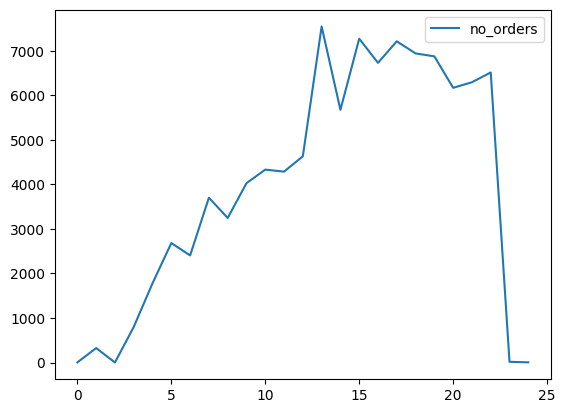

In [11]:
orders_bymonth.plot()
plt.show()

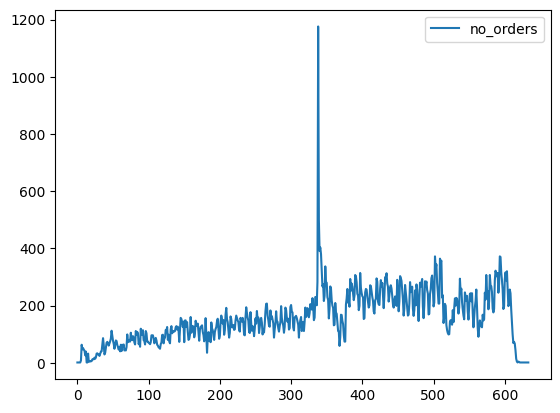

In [12]:
orders_bydate.plot()
plt.show()

In [22]:
orders_bydate_filtered = orders_bydate.loc[orders_bydate['no_orders'] < 400]

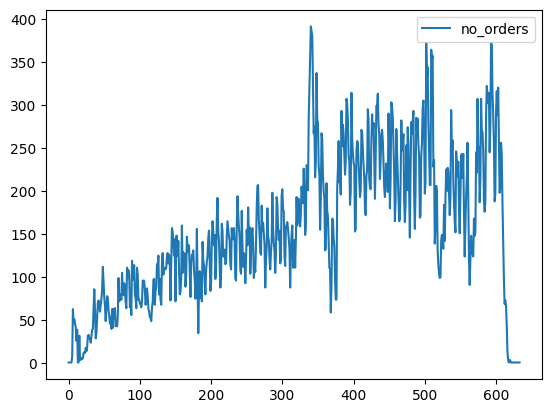

In [23]:
orders_bydate_filtered.plot()
plt.show()

# LSTM Pytorch

In [31]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.utils.data as data

In [27]:
orders_bydate_lstm = orders_bydate_filtered[["no_orders"]].values.astype('float32')

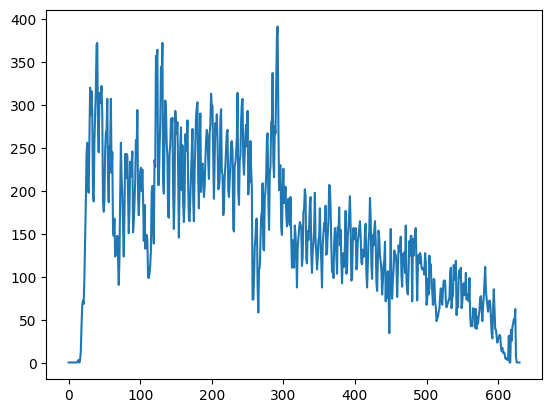

In [28]:
plt.plot(orders_bydate_lstm)
plt.show()

In [29]:
orders_bydate_lstm

array([[  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  1.],
       [  3.],
       [  4.],
       [  1.],
       [  4.],
       [ 14.],
       [ 44.],
       [ 67.],
       [ 73.],
       [ 69.],
       [ 99.],
       [144.],
       [187.],
       [243.],
       [256.],
       [204.],
       [198.],
       [257.],
       [320.],
       [288.],
       [316.],
       [292.],
       [197.],
       [188.],
       [256.],
       [289.],
       [316.],
       [370.],
       [372.],
       [276.],
       [245.],
       [314.],
       [302.],
       [311.],
       [322.],
       [288.],
       [188.],
       [176.],
       [189.],
       [247.],
       [268.],
       [271.],
       [307.],
       [215.],
       [187.],
       [250.],
       [253.],
       [307.],
       [221.],
       [245.],
       [152.],
       [148.],
       [168.],
       [124.],
       [12

In [32]:
# train-test split for time series
train_size = int(len(orders_bydate_lstm) * 0.67)
test_size = len(orders_bydate_lstm) - train_size
train, test = orders_bydate_lstm[:train_size], orders_bydate_lstm[train_size:]

In [33]:
print(train_size, test_size)

422 209


In [34]:
# Function create dataset
def create_dataset(dataset, lookback):
    X, y = [], [] 
    for i in range(len(dataset)-lookback):
        feature = dataset[i : i+lookback]
        target = dataset[i+1: i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [35]:
#Try with lookback = 1
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([421, 1, 1]) torch.Size([421, 1, 1])
torch.Size([208, 1, 1]) torch.Size([208, 1, 1])


/var/folders/yt/4vlc63d57rz84q0w40rbc23w0000gn/T/ipykernel_9670/942699040.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  return torch.tensor(X), torch.tensor(y)


In [36]:
#The LSTM model is created as a class
#The output of nn.LSTM() is a tuple. The first element is the generated hidden states, one for each time step of the input. 
#The second element in the LSTM cell's memory and hidden states, which is not used here.
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size = 50, num_layers = 1, batch_first = True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return(x)

In [37]:
#Train the model
model = LSTMModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)


In [38]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 203.8544, test RMSE 89.4439
Epoch 100: train RMSE 71.4518, test RMSE 30.9940
Epoch 200: train RMSE 41.4149, test RMSE 36.0626
Epoch 300: train RMSE 39.5234, test RMSE 28.5347
Epoch 400: train RMSE 40.2008, test RMSE 27.2509
Epoch 500: train RMSE 39.8988, test RMSE 31.7895
Epoch 600: train RMSE 39.0021, test RMSE 29.4551
Epoch 700: train RMSE 38.8072, test RMSE 32.0326
Epoch 800: train RMSE 38.7952, test RMSE 29.4215
Epoch 900: train RMSE 38.5995, test RMSE 30.2155
Epoch 1000: train RMSE 39.2209, test RMSE 27.5375
Epoch 1100: train RMSE 38.5749, test RMSE 32.1770
Epoch 1200: train RMSE 38.8824, test RMSE 33.5088
Epoch 1300: train RMSE 38.4985, test RMSE 32.0240
Epoch 1400: train RMSE 38.6954, test RMSE 32.2383
Epoch 1500: train RMSE 39.2975, test RMSE 26.3630
Epoch 1600: train RMSE 38.8194, test RMSE 30.5479
Epoch 1700: train RMSE 40.5352, test RMSE 33.3197
Epoch 1800: train RMSE 38.7133, test RMSE 32.3342
Epoch 1900: train RMSE 39.0755, test RMSE 25.3126


In [39]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(orders_bydate_lstm) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(orders_bydate_lstm) * np.nan
    test_plot[train_size+lookback:len(orders_bydate_lstm)] = model(X_test)[:, -1, :]

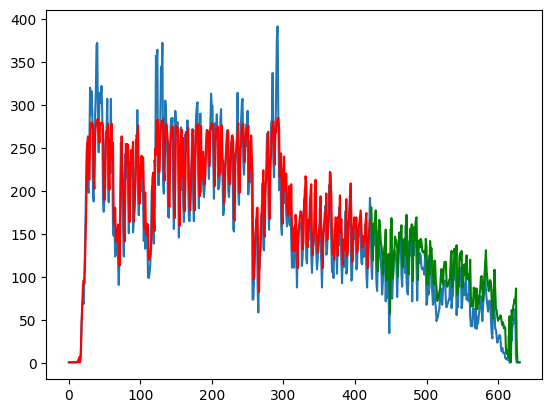

In [40]:
# plot
plt.plot(orders_bydate_lstm)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()